In [1]:
import sys
sys.path.append('/scratch/ne2213/projects/tmp_packages')
sys.path.append('/scratch/ne2213/projects/tmp_packages/')
import torch
import numpy as np

import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
import torchvision.transforms.functional as F_t

import warnings
warnings.filterwarnings("ignore")

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import random
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.transforms import ToPILImage


import torchvision.utils as vutils
import torch.nn.functional as F
import matplotlib.pyplot as plt

***We define some helper functions that we later use for building our GAN:***

In [2]:
# operations
def batch_norm_2d(x):
    x_shape = x.shape[1]
    batch_nor = nn.BatchNorm2d(x_shape, eps=1e-05, momentum=0.9, affine=True)
    batch_nor = batch_nor.cuda()
    output = batch_nor(x)
    return output


def batch_norm_1d(x):
    x_shape = x.shape[1]
    batch_nor = nn.BatchNorm1d(x_shape, eps=1e-05, momentum=0.9, affine=True)
    batch_nor = batch_nor.cuda()
    output = batch_nor(x)
    return output


def lrelu(x, leak=0.2):
    z = torch.mul(x,leak)
    return torch.max(x, z)


def conv_cond_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = x.shape
    y_shapes = y.shape
    y2 = y.expand(x_shapes[0],y_shapes[1],x_shapes[2],x_shapes[3])
    return torch.cat((x, y2),1)


def conv_prev_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = x.shape
    y_shapes = y.shape
    if x_shapes[2:] == y_shapes[2:]:
        y2 = y.expand(x_shapes[0],y_shapes[1],x_shapes[2],x_shapes[3])
        return torch.cat((x, y2),1)
    else:
        print(x_shapes[2:])
        print(y_shapes[2:])

***The Generator architecture for for generating 4-bar segments of music: The generator takes as input a noise vector z, a previous sample prev_x, and a condition y (representing emotion).***

***It first processes the previous sample prev_x through convolutional layers (h0_prev, h1_prev, h2_prev, h3_prev) to extract features, then concatenates the condition y with the noise vector z and passes it through linear layers (linear1 and linear2) to generate intermediate representations. The intermediate representation is reshaped and concatenated with the condition y. The reshaped representation is then passed through additional convolutional layers (h1, h2, h3, h4) to generate the final output. Each convolutional layer is followed by a leaky ReLU activation function and batch normalization.***

In [3]:
# generator (4-bar segments)
class generator(nn.Module):
    def __init__(self,pitch_range):
        super(generator, self).__init__()
        self.gf_dim = 64
        self.y_dim = 4
        self.n_channel = 256

        self.h1 = nn.ConvTranspose2d(196, pitch_range, (2,1), (2,2))
        self.h2 = nn.ConvTranspose2d(196, pitch_range, (2,1), (2,2))
        self.h3 = nn.ConvTranspose2d(196, pitch_range, (2,1), (2,2))
        self.h4 = nn.ConvTranspose2d(196, 1, (1,pitch_range), (1,2))

        self.h0_prev = nn.Conv2d(1, 64, (1,pitch_range), (1,2))
        self.h1_prev = nn.Conv2d(64, 64, (2,1), (2,2))
        self.h2_prev = nn.Conv2d(64, 64, (2,1), (2,2))
        self.h3_prev = nn.Conv2d(64, 64, (2,1), (2,2))

        self.linear1 = nn.Linear(404,2048)
        self.linear2 = nn.Linear(2052,self.gf_dim*8*2*1)

    def forward(self, z, prev_x, y ,batch_size=72, pitch_range=128):

        h0_prev = lrelu(batch_norm_2d(self.h0_prev(prev_x)),0.2)   #[72, 64, 64, 1]
        h1_prev = lrelu(batch_norm_2d(self.h1_prev(h0_prev)),0.2)  #[72, 64, 32, 1]
        h2_prev = lrelu(batch_norm_2d(self.h2_prev(h1_prev)),0.2)  #[72, 64, 16, 1]
        h3_prev = lrelu(batch_norm_2d(self.h3_prev(h2_prev)),0.2)  #[72, 64, 8, 1])

        yb = y.view(batch_size,  self.y_dim, 1, 1)  #(72,4,1,1)

        z = torch.cat((z,y),1)         #(72,404)

        h0 = F.relu(batch_norm_1d(self.linear1(z)))    #(72,2048)
        h0 = torch.cat((h0,y),1)   #(72,2052)

        h1 = F.relu(batch_norm_1d(self.linear2(h0)))   #(72, 1024)
        h1 = h1.view(batch_size, self.gf_dim * 2, 8, 1)     #(72,128,8,1)
        h1 = conv_cond_concat(h1,yb) #(72,132,8,1)
        h1 = conv_prev_concat(h1,h3_prev)  #(72, 196, 8, 1)

        h2 = F.relu(batch_norm_2d(self.h1(h1)))  #(72, 128, 8, 1)
        h2 = conv_cond_concat(h2,yb) #([72, 132, 8, 1])
        h2 = conv_prev_concat(h2,h2_prev)  #([72, 196, 16, 1])

        h3 = F.relu(batch_norm_2d(self.h2(h2)))  #([72, 128, 16, 1]) 
        h3 = conv_cond_concat(h3,yb)  #([72, 132, 16, 1])
        h3 = conv_prev_concat(h3,h1_prev) #([72, 196, 32, 1])

        h4 = F.relu(batch_norm_2d(self.h3(h3)))  #([72, 128, 32, 1])
        h4 = conv_cond_concat(h4,yb)  #([72, 132, 32, 1])
        h4 = conv_prev_concat(h4,h0_prev) #([72, 198, 64, 1])

        g_x = torch.sigmoid(self.h4(h4)) #([72, 1, 64, 128])

        return g_x

***The discriminator takes two inputs: x: Input musical segment, y: Emotion label.***


***Architecture: The initial convolutional layer takes the input musical segment (x) with 5 channels (including the emotion label channel) and performs convolution with a kernel size of (2, pitch_range), where pitch_range represents the range of pitches in the music. The subsequent convolutional layer takes the output of the first layer and performs convolution with a kernel size of (8,1). It also incorporates the emotion label information. The first linear layer reduces the dimensionality of the data to dfc_dim. The second linear layer further processes the data and produces a single output representing the discriminator's decision. The emotion label (y) is concatenated with the intermediate feature maps at different stages of the network. The output of the discriminator is a single value obtained after passing through a sigmoid activation function, representing the discriminator's confidence in the input being real (1) or fake (0).***

In [4]:
# discriminator
class discriminator(nn.Module):
    def __init__(self,pitch_range):
        super(discriminator, self).__init__()

        self.df_dim = 64
        self.dfc_dim = 1024
        self.y_dim = 4

        self.h0_prev = nn.Conv2d(5, 5, (2,pitch_range), (2,2))
        #out channels = y_dim +1 
        self.h1_prev = nn.Conv2d(9, 68, (8,1), (4,2))
        # out channels = df_dim + y_dim
        self.linear1 = nn.Linear(480,self.dfc_dim)
        self.linear2 = nn.Linear(1028,1)

    def forward(self,x,y,batch_size,pitch_range):        

        yb = y.view(batch_size,self.y_dim, 1, 1)
        x = conv_cond_concat(x, yb)  #x.shape torch.Size([72, 5, 64, 128])
        
        h0 = lrelu(self.h0_prev(x),0.2)
        h0 = conv_cond_concat(h0, yb) #torch.Size([72, 9, 32, 1])

        h1 = lrelu(batch_norm_2d(self.h1_prev(h0)),0.2)  #torch.Size([72, 68, 7, 1])
        h1 = h1.view(batch_size, -1)  #torch.Size([72, 476])
        h1 = torch.cat((h1,y),1)  #torch.Size([72, 480])

        h2 = lrelu(batch_norm_1d(self.linear1(h1)))
        h2 = torch.cat((h2,y),1)  #torch.Size([72, 1028])

        h3 = self.linear2(h2)
        h3_sigmoid = torch.sigmoid(h3) #torch.Size([72, 1])

        return h3_sigmoid

***We define this class which initializes with musical data, previous musical data, and emotion labels, converting them into PyTorch tensors. It preprocesses the dataset, and creates a DataLoader instance configured for batch training with shuffling.***

In [5]:
# dataloader class
class get_dataloader(object):
    def __init__(self, data, prev_data, y):
        self.size = data.shape[0]
        self.data = torch.from_numpy(data).float()
        self.prev_data = torch.from_numpy(prev_data).float()
        self.y   = torch.from_numpy(y).float()

         # self.label = np.array(label)
    def __getitem__(self, index):
        return self.data[index],self.prev_data[index], self.y[index]

    def __len__(self):
        return self.size


def load_data():
    #######load the data########
    check_range_st = 0
    check_range_ed = 129
    pitch_range = check_range_ed - check_range_st-1

    # load saved data arrays
    X_tr = np.load('X_tr.npy')
    prev_X_tr = np.load('X_prev_tr.npy')
    y_tr = np.load('y_tr.npy')
    X_tr = X_tr[:,:,:,check_range_st:check_range_ed]
    prev_X_tr = prev_X_tr[:,:,:,check_range_st:check_range_ed]

    print(X_tr.shape)

    train_iter = get_dataloader(X_tr,prev_X_tr,y_tr)
    kwargs = {'num_workers': 1, 'pin_memory': True}# if args.cuda else {}
    train_loader = DataLoader(
                   train_iter, batch_size=72, shuffle=True, **kwargs)

    return train_loader

In [6]:
# prepare dataset
device = torch.device('cuda')
train_loader = load_data()
pitch_range = 128
netG = generator(pitch_range).to(device)
netD = discriminator(pitch_range).to(device)  

(16844, 1, 64, 128)


In [7]:
# hyperparameters
batch_size = 72
epochs = 30
lr = 0.0002

# optimizers
netD.train()
netG.train()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999)) 

In [8]:
# variables and storage
nz = 400
fixed_noise = torch.randn(batch_size, nz, device=device) # for outputting results at epochs
average_lossD = 0
average_lossG = 0
average_D_x   = 0
average_D_G_z = 0

lossD_list =  []
lossG_list =  []
D_x_list = []
D_G_z_list = []

In [9]:
# criterion
criterion = nn.BCELoss()

In [10]:
train_loader = load_data()

(16844, 1, 64, 128)


***Next we train our model for 30 epochs (increasing the number of epochs didn't improve the results):***

***Within each epoch, the training loop iterates through the data batches. For each batch:
Real and fake samples of melodies are generated.
The Discriminator (netD) is trained to distinguish between real and fake melodies.
The Generator (netG) is trained to fool the Discriminator by generating more realistic melodies.
Losses are computed and backpropagated through both networks.
At the end of each epoch, average losses and discriminator outputs are computed and saved, and model checkpoints are stored.***

In [11]:
# train GAN
for epoch in range(epochs):
    sum_lossD = 0
    sum_lossG = 0
    sum_D_x   = 0
    sum_D_G_z = 0
    for i, (data,prev_data,label) in enumerate(train_loader, 0):
        # inputs to models
        real_mel = data.to(device)
        prev_mel = prev_data.to(device)
        mood = label.to(device)
        batch_size = real_mel.size(0)
        z = torch.randn(batch_size, nz, device=device)

        # generate a fake sample
        fake_mel = netG(z,prev_mel,mood,batch_size,pitch_range)

        ############################
        # (1) Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real melody
        netD.zero_grad()
        D = netD(real_mel,mood,batch_size,pitch_range)

        # loss
        d_loss_real = criterion(D, torch.ones_like(D))
        d_loss_real.backward()
        D_x = D.mean().item()
        sum_D_x += D_x 

        # train with fake melody
        D = netD(fake_mel.detach(),mood,batch_size,pitch_range)

        # loss
        d_loss_fake = criterion(D, torch.zeros_like(D))
        d_loss_fake.backward()
        D_G_z1 = D.mean().item()

        # total loss
        errD = d_loss_real + d_loss_fake
        errD = errD.item()
        sum_lossD += errD
        optimizerD.step()
        
        ###########################
        # (2) Train Generator: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()

        # get discriminator feedback        
        D = netD(fake_mel,mood,batch_size,pitch_range)

        # loss
        g_loss = criterion(D, torch.ones_like(D))
        g_loss.backward()
        g_loss = g_loss.item()
        sum_lossG += g_loss

        D_G_z2 = D.mean().item()
        sum_D_G_z += D_G_z2
        optimizerG.step()
        

        if i % 100 == 0:
            # store generated image from batch size using fixed noise each epoch
            vutils.save_image(real_mel,
                    '/scratch/ne2213/projects/DL/DL-FinalProject/GAN/Res/real_samples.png',
                    normalize=True)
            fake = netG(fixed_noise,prev_mel,mood,batch_size,pitch_range)
            vutils.save_image(fake_mel.detach(),
                    '/scratch/ne2213/projects/DL/DL-FinalProject/GAN/Res/fake_samples_epoch_%03d.png' % (epoch),
                    normalize=True)

    average_lossD = (sum_lossD / len(train_loader.dataset))
    average_lossG = (sum_lossG / len(train_loader.dataset))
    average_D_x = (sum_D_x / len(train_loader.dataset))
    average_D_G_z = (sum_D_G_z / len(train_loader.dataset))

    lossD_list.append(average_lossD)
    lossG_list.append(average_lossG)            
    D_x_list.append(average_D_x)
    D_G_z_list.append(average_D_G_z)

    # do checkpointing
    torch.save(netG.state_dict(), '/scratch/ne2213/projects/DL/DL-FinalProject/GAN/Res/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), '/scratch/ne2213/projects/DL/DL-FinalProject/GAN/Res/netD_epoch_%d.pth' % (epoch))
    print('==> Epoch: {} Average lossD: {:.10f} average_lossG: {:.10f},average D(x): {:.10f},average D(G(z)): {:.10f} '.format(
      epoch, average_lossD,average_lossG,average_D_x, average_D_G_z)) 

==> Epoch: 0 Average lossD: 0.0101014559 average_lossG: 0.0180264961,average D(x): 0.0097759526,average D(G(z)): 0.0040073690 
==> Epoch: 1 Average lossD: 0.0172559692 average_lossG: 0.0123683937,average D(x): 0.0076669679,average D(G(z)): 0.0060646204 
==> Epoch: 2 Average lossD: 0.0188488050 average_lossG: 0.0102372527,average D(x): 0.0071197788,average D(G(z)): 0.0067043728 
==> Epoch: 3 Average lossD: 0.0186246660 average_lossG: 0.0105244820,average D(x): 0.0071769948,average D(G(z)): 0.0065993631 
==> Epoch: 4 Average lossD: 0.0189128998 average_lossG: 0.0102530975,average D(x): 0.0070973759,average D(G(z)): 0.0067020371 
==> Epoch: 5 Average lossD: 0.0190484084 average_lossG: 0.0099541890,average D(x): 0.0070472169,average D(G(z)): 0.0068188815 
==> Epoch: 6 Average lossD: 0.0188019892 average_lossG: 0.0103089692,average D(x): 0.0071207762,average D(G(z)): 0.0066716620 
==> Epoch: 7 Average lossD: 0.0189420241 average_lossG: 0.0101335403,average D(x): 0.0070761608,average D(G(z))

In [13]:
np.save('/scratch/ne2213/projects/DL/DL-FinalProject/GAN/Res/lossD_list.npy',lossD_list)
np.save('/scratch/ne2213/projects/DL/DL-FinalProject/GAN/Res/ossG_list.npy',lossG_list)
np.save('/scratch/ne2213/projects/DL/DL-FinalProject/GAN/Res/D_x_list.npy',D_x_list)
np.save('/scratch/ne2213/projects/DL/DL-FinalProject/GAN/Res/D_G_z_list.npy',D_G_z_list)

***Plot the evolution of the generator and discriminator losses. We couldn't acheive a good converagnce even by changing the hyperparameters or the loss function (using hinge loss instead)***

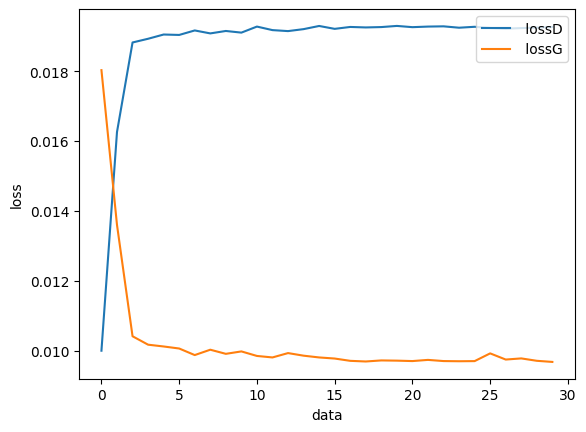

In [14]:
lossD_print = np.load('lossD_list.npy')
lossG_print = np.load('lossG_list.npy')

length = lossG_print.shape[0]

x = np.linspace(0, length-1, length)
x = np.asarray(x)
plt.figure()
plt.plot(x, lossD_print,label=' lossD',linewidth=1.5)
plt.plot(x, lossG_print,label=' lossG',linewidth=1.5)

plt.legend(loc='upper right')
plt.xlabel('data')
plt.ylabel('loss')
plt.savefig('/scratch/ne2213/projects/DL/DL-FinalProject/GAN/Res/loss_curves.png')